In [1]:
# dataDir = "/home/ababil/BUET/AV/csv"
dataDir = "D:/AV/Code/location-2"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2"

In [2]:
exec(open('init_notebook.py').read())

current working dirD:\AV\Code\behavior-hypotheses\src


In [3]:
%load_ext autoreload
%autoreload 2

In [51]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper

In [5]:
sceneId = 210
sceneId2 = 211
date = "2023-05-04"
fps=10
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
pedDf2 = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId2}-pedestrians.csv"))
# otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

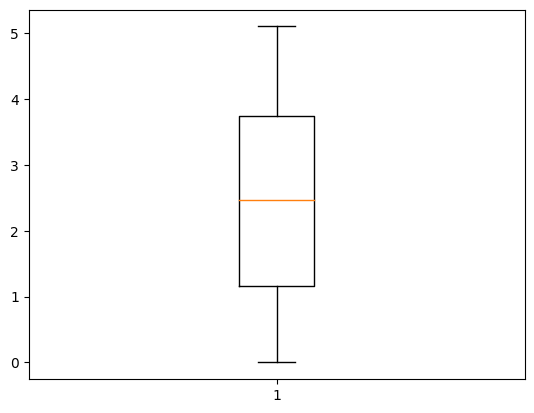

{'whiskers': [<matplotlib.lines.Line2D at 0x2a1af03eeb0>,
 'caps': [<matplotlib.lines.Line2D at 0x2a1af04e160>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a1af03ec10>],
 'medians': [<matplotlib.lines.Line2D at 0x2a1af04e790>],
 'fliers': [<matplotlib.lines.Line2D at 0x2a1af04ea30>],
 'means': []}

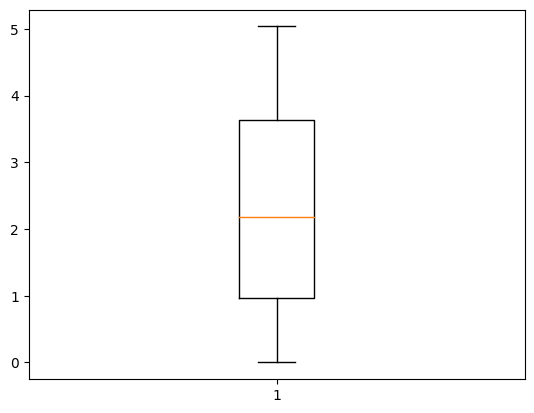

In [6]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity', 
        speedCol='speed',
        xAccCol='sceneXAcceleration',
        yAccCol='sceneYAcceleration',
        accelerationCol='acceleration'
        
    
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minAcceleration = -10.0,
    maxAcceleration = 10.0,
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
transformer.deriveAcceleration(pedDf)

transformer.deriveSpeed(pedDf2)
transformer.deriveDisplacements(pedDf2)
transformer.deriveAcceleration(pedDf2)

plt.boxplot(pedDf['displacementY'])
plt.show()
plt.boxplot(pedDf2['displacementY'])

In [8]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate(trackDf)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


using min Y displacement (5)


7600

In [43]:
cleanPedDf_copy = cleanPedDf.copy()
# cleanPedDf_copy.head(10)

def assign_category(speed):
    if speed < 0.4:
        # print("A")
        return 1
    elif (speed >= 0.4) & (speed < 2*0.4):
        return 2
    else:
        return 3
    
cleanPedDf_copy["Bucket"] = cleanPedDf_copy["speed"].apply(assign_category)
cleanPedDf_copy.head(10)

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,Bucket
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,2
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,2
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,2
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,2
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,2
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023,2
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184,2
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701,2
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228,2
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489,2


In [44]:

# Find the minimum and maximum values
min_value = cleanPedDf_copy["speed"].min()
max_value = cleanPedDf_copy["speed"].max()

# Print the results
print(f"Minimum: {min_value}")
print(f"Maximum: {max_value}")

Minimum: 0.18725550726214213
Maximum: 1.1156748327805872


In [45]:
# Boolean indexing to filter rows
selected_rows = cleanPedDf_copy[cleanPedDf_copy["speed"] < 0.4]

# Print the selected rows
selected_rows

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,Bucket
1325,18,20704,18313,210,5.0,1.023349,0.656938,0.005271,0.296247,-0.007759,-0.124922,0.296293,0.393950,1.797915,0.125162,-0.000000,-0.000000,1
1326,18,20706,18313,210,5.0,1.021979,0.591763,0.006854,0.325879,-0.007912,-0.148162,0.325951,0.392579,1.863091,0.148373,0.001371,0.065176,1
1327,18,20708,18313,210,5.0,1.019234,0.521400,0.013725,0.351813,-0.034358,-0.129671,0.352081,0.389834,1.933454,0.134146,0.004116,0.135538,1
1328,18,20710,18313,210,5.0,1.015656,0.444281,0.017890,0.385594,-0.020826,-0.168906,0.386009,0.386256,2.010573,0.170185,0.007694,0.212657,1
1942,19,9167,19133,210,5.0,-0.096706,2.428678,-0.052315,0.367436,-0.019901,0.016823,0.371142,0.726106,0.026176,0.026059,-0.000000,-0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20433,27,24609,27448,210,5.0,-0.370382,2.275009,-0.150714,0.364412,0.100543,0.122303,0.394349,0.999782,0.179845,0.158325,-0.056264,0.150657,1
20434,27,24611,27448,210,5.0,-0.335940,2.206601,-0.172213,0.342042,0.107496,0.111852,0.382949,0.965340,0.248253,0.155133,-0.090707,0.219065,1
20435,27,24613,27448,210,5.0,-0.298712,2.141285,-0.186136,0.326579,0.069613,0.077312,0.375900,0.928112,0.313569,0.104034,-0.127934,0.284381,1
20436,27,24615,27448,210,5.0,-0.257343,2.078810,-0.206846,0.312376,0.103548,0.071017,0.374652,0.886743,0.376044,0.125561,-0.169303,0.346856,1


In [46]:
# Find the minimum and maximum values
min_value = cleanPedDf_copy["acceleration"].min()
max_value = cleanPedDf_copy["acceleration"].max()

# Print the results
print(f"Minimum: {min_value}")
print(f"Maximum: {max_value}")

Minimum: 0.0005590169945053466
Maximum: 0.3495376410345918


In [47]:
def assign_acc_category(acc):
    if acc < 0.1:
        # print("A")
        return 1
    elif (acc >= 0.1) & (acc < 2*0.1):
        return 2
    else:
        return 3
    
cleanPedDf_copy["accBucket"] = cleanPedDf_copy["acceleration"].apply(assign_acc_category)
cleanPedDf_copy.head(10)

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,Bucket,accBucket
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,2,1
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,2,1
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,2,1
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,2,1
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,2,1
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023,2,1
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184,2,1
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701,2,1
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228,2,1
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489,2,1


In [9]:

# firstDf = cleanPedDf[cleanPedDf["speed"] < 1].copy()
# secondDf = cleanPedDf[(cleanPedDf["speed"] >= 1) & (cleanPedDf["speed"] < 2)].copy()
# thirdDf = cleanPedDf[(cleanPedDf["speed"] >= 2)].copy()


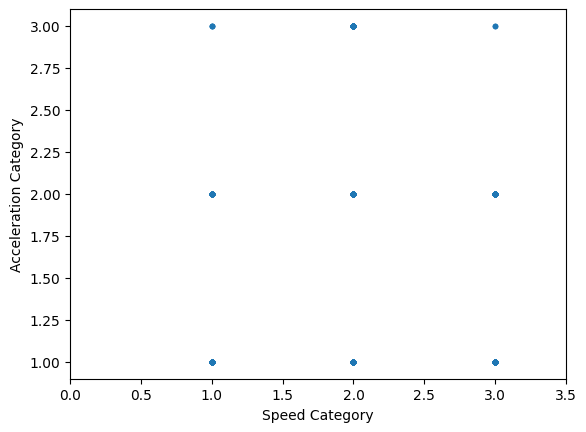

In [48]:
# numeric_col = ['speed','sceneYAcceleration']

# startingDf_copy = firstDf
 
# # Correlation Matrix formation
# corr_matrix = startingDf_copy.loc[:,numeric_col].corr()
# # correlation_matrix = startingDf.corr()
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.scatter(cleanPedDf_copy["Bucket"], cleanPedDf_copy["accBucket"], marker = ".")

plt.xlim(0.0,3.5) 
plt.xlabel('Speed Category')
plt.ylabel('Acceleration Category')
plt.show()


<AxesSubplot: >

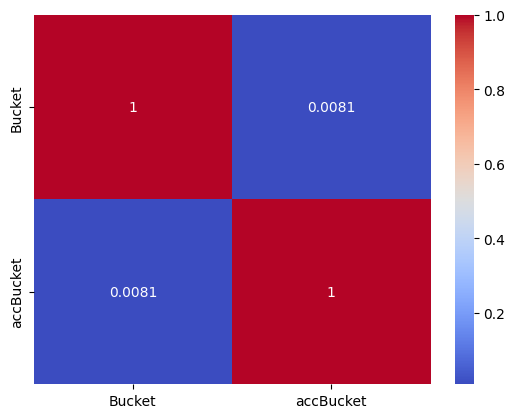

In [49]:
numeric_col_dis = ['Bucket','accBucket']
startingDf_copy2 = cleanPedDf_copy
# Correlation Matrix formation
corr_matrix_dis = startingDf_copy2.loc[:,numeric_col_dis].corr()
# correlation_matrix = startingDf.corr()
sns.heatmap(corr_matrix_dis, annot=True, cmap='coolwarm')

In [ ]:

plt.rc('font', size=20)
plt.rc('axes', labelsize=28) #fontsize of the x and y labels
plt.scatter(midEditedDf["speed"], midEditedDf["acceleration"], marker = ".")
for pedId in allPedIds:
    uniqueTrackId_collection[pedId] = midEditedDf[midEditedDf["uniqueTrackId"] == pedId].copy()
    plt.plot(uniqueTrackId_collection[pedId]["displacementY"], uniqueTrackId_collection[pedId]["acceleration"])
plt.xlabel('Crossed Road Width (m)')
plt.ylabel('Acceleration ($\mathregular{m/s^{2}}$)')
plt.grid()
# plt.savefig("MidAccelerationVsCrossedRoadWidth.png",bbox_inches="tight")
plt.show()


7600

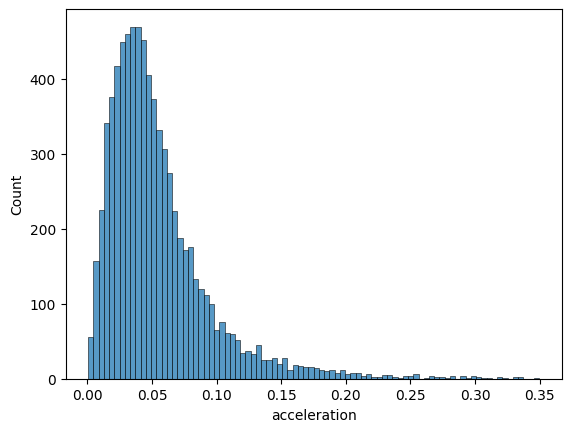

In [60]:
sns.histplot(cleanPedDf_copy["acceleration"])
len(cleanPedDf_copy)

[[8.000e+01 2.300e+01 5.000e+00]
 [6.628e+03 6.390e+02 8.200e+01]
 [1.050e+02 3.500e+01 3.000e+00]]


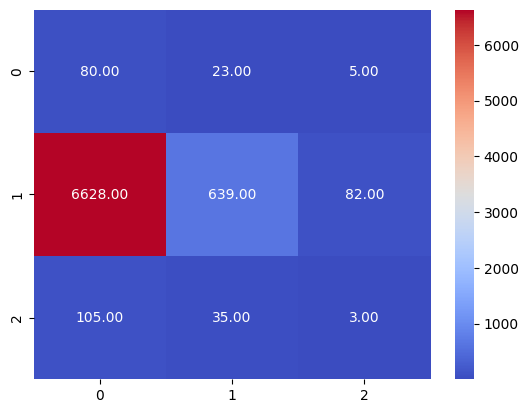

In [70]:
# Generate some example data
data = np.zeros((3,3))

for index, row in cleanPedDf_copy.iterrows():
    data[cleanPedDf_copy.loc[index, "Bucket"]-1][cleanPedDf_copy.loc[index, "accBucket"]-1] += 1
        
print(data)

# Create a heatmap using Seaborn
sns.heatmap(data, cmap='coolwarm', annot=True, fmt=".2f")

# Show the plot
plt.show()

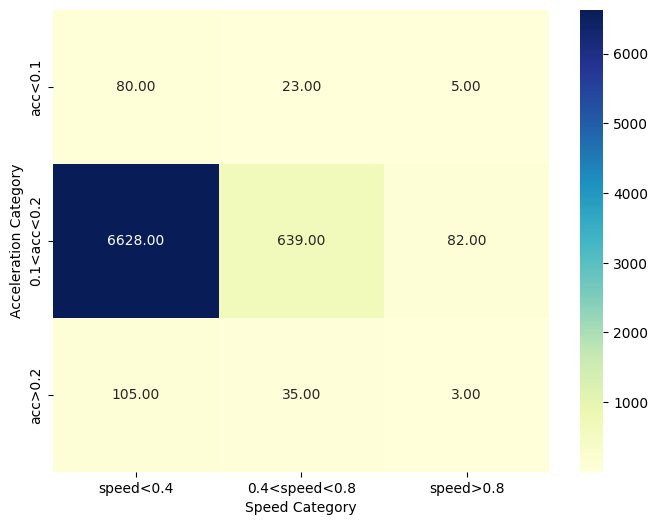

In [79]:
# Generate example data
# data = np.random.rand(3, 3)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap='YlGnBu')

# Customize the axis labels
plt.xlabel("Speed Category")
plt.ylabel("Acceleration Category")

# Customize the tick labels
x_labels = ["speed<0.4", "0.4<speed<0.8", "speed>0.8"]
y_labels = ["acc<0.1", "0.1<acc<0.2", "acc>0.2"]
plt.xticks([0.5, 1.5, 2.5], x_labels)
plt.yticks([0.5, 1.5, 2.5], y_labels)

# # Customize the annotation format
# plt.gca().set_xticks(np.arange(3) + 0.5, minor=True)
# plt.gca().set_yticks(np.arange(3) + 0.5, minor=True)
# plt.gca().xaxis.set_tick_params(which="minor", size=0)
# plt.gca().yaxis.set_tick_params(which="minor", size=0)

# Show the plot
plt.show()
